<a href="https://colab.research.google.com/github/Soomro2023/Project6/blob/main/Project6_voice_cloning_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mozillaorg/common-voice
!unzip /content/common-voice.zip

Streaming output truncated to the last 5000 lines.
  inflating: cv-valid-train/cv-valid-train/sample-190776.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190777.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190778.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190779.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190780.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190781.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190782.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190783.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190784.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190785.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190786.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190787.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190788.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190789.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190790.mp3  
  in

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [ ]:
import os
import random
import shutil
# import librosa
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
files_list = []

for root, dirs, files in os.walk("/content/cv-other-test/cv-other-test"):
    for file in files:
        if file.endswith(".mp3") :
            files_list.append(os.path.join(root, file))

#
filesToCopy = random.sample(files_list, 160)

destPath = "/content/drive/MyDrive/real_audio"


# iteraate over all random files and move them
for file in filesToCopy:
    shutil.move(file, destPath)

# Fake Audios

In [ ]:
fake_file_list = os.listdir('/content/drive/MyDrive/synthesized_audio_long_version')
#read them into pandas
fake_df = pd.DataFrame(fake_file_list)
# Renaming the column name to file
fake_df = fake_df.rename(columns={0:'file'})
fake_df['real'] = 0
fake_df.file = [f"/content/drive/MyDrive/synthesized_audio_long_version/{i}" for i in fake_df.file]
fake_df.head(2)

,file,real
0,/content/drive/MyDrive/synthesized_audio_long_...,0
1,/content/drive/MyDrive/synthesized_audio_long_...,0


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#Real Audios

In [ ]:
#list the files
real_file_list = os.listdir("/content/drive/MyDrive/real_audio")
#read them into pandas
real_df = pd.DataFrame(real_file_list)
# Renaming the column name to file
real_df = real_df.rename(columns={0:'file'})
real_df['real'] = 1
real_df.file = [f"/content/drive/MyDrive/real_audio/{i}" for i in real_df.file]
real_df.head(2)

,file,real
0,/content/drive/MyDrive/real_audio/sample-00008...,1
1,/content/drive/MyDrive/real_audio/sample-00028...,1


#

In [ ]:
df = pd.concat([real_df, fake_df], axis=0)
df.head(2)

,file,real
0,/content/drive/MyDrive/real_audio/sample-00008...,1
1,/content/drive/MyDrive/real_audio/sample-00028...,1



#



In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,file,real
0,/content/drive/MyDrive/real_audio/sample-00069...,1
1,/content/drive/MyDrive/synthesized_audio_long_...,0
2,/content/drive/MyDrive/synthesized_audio_long_...,0
3,/content/drive/MyDrive/synthesized_audio_long_...,0
4,/content/drive/MyDrive/synthesized_audio_long_...,0


#Split the files into train, test and val

In [ ]:
from sklearn.model_selection import train_test_split
X = df[['file']]
y = df.real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)


print(f"X_train length is: {len(X_train)}, y_train length is: {len(y_train)}")
print(f"X_test length is: {len(X_test)}, y_test length is: {len(y_test)}")
print(f"X_val length is: {len(X_val)}, y_val length is: {len(y_val)}")

X_train length is: 267, y_train length is: 267
X_test length is: 34, y_test length is: 34
X_val length is: 30, y_val length is: 30


#Feature Extraction

In [ ]:
def extract_features(files):
  """
  return mfccs, chroma, mel, contrast and tonnetz for each audio file
  """
  df = {'mfccs' : [], 'chroma' : [], 'mel' : [], 'contrast' : [], 'tonnetz' : []}
  for file_name in files:
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    df['mfccs'].append(mfccs)
    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    df['chroma'].append(chroma)
    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    # mel = np.mean(librosa.feature.melspectrogram(X).T,axis=0)
    df['mel'].append(mel)
    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    df['contrast'].append(contrast)
    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    df['tonnetz'].append(tonnetz)
  return df

In [ ]:
!pip install librosa==0.9.2

In [ ]:
import librosa

In [ ]:
val_features = extract_features(X_val.file)
train_features = extract_features(X_train.file)
test_features = extract_features(X_test.file)

In [ ]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

In [ ]:
def concat_features(features):
  features_list = []
  for i in range(0, len(features['mfccs'])):
      features_list.append(np.concatenate((
          scalar.fit_transform((features['mfccs'][i]).reshape(-1, 1)),
          scalar.fit_transform((features['chroma'][i]).reshape(-1, 1)),
          scalar.fit_transform((features['mel'][i]).reshape(-1, 1)),
          scalar.fit_transform((features['contrast'][i]).reshape(-1, 1)),
          scalar.fit_transform((features['tonnetz'][i]).reshape(-1, 1))), axis=0))
  return np.array(features_list).reshape(len(features['mfccs']), 193)

In [ ]:
X_val_data = concat_features(val_features)
X_train_data = concat_features(train_features)
X_test_data = concat_features(test_features)

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
import tensorflow as tf

In [ ]:
# 1) create the model
model_1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=50, input_shape=(193,), activation='relu'),
                             tf.keras.layers.Dense(units=50, activation='relu'),
                            #  tf.keras.layers.Dense(units=50, activation='relu'),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')])
# 2) compile the model
model_1.compile(loss='binary_crossentropy', metrics=tf.keras.metrics.AUC(), optimizer='adam')
# 3) fit the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
hist_1 = model_1.fit(X_train_data, y_train, validation_data=(X_val_data, y_val), epochs=2000, callbacks=[early_stop])

Epoch 1/2000
9/9 [==============================] - 1s 37ms/step - loss: 0.6648 - auc_1: 0.6476 - val_loss: 0.4715 - val_auc_1: 0.9569
Epoch 2/2000
9/9 [==============================] - 0s 10ms/step - loss: 0.4804 - auc_1: 0.9212 - val_loss: 0.3323 - val_auc_1: 0.9665
Epoch 3/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.3564 - auc_1: 0.9521 - val_loss: 0.2324 - val_auc_1: 0.9761
Epoch 4/2000
9/9 [==============================] - 0s 9ms/step - loss: 0.2755 - auc_1: 0.9686 - val_loss: 0.1821 - val_auc_1: 0.9809
Epoch 5/2000
9/9 [==============================] - 0s 12ms/step - loss: 0.2146 - auc_1: 0.9799 - val_loss: 0.1533 - val_auc_1: 0.9856
Epoch 6/2000
9/9 [==============================] - 0s 11ms/step - loss: 0.1762 - auc_1: 0.9875 - val_loss: 0.1358 - val_auc_1: 0.9856
Epoch 7/2000
9/9 [==============================] - 0s 13ms/step - loss: 0.1455 - auc_1: 0.9922 - val_loss: 0.1116 - val_auc_1: 0.9952
Epoch 8/2000
9/9 [==============================] - 0s 1

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

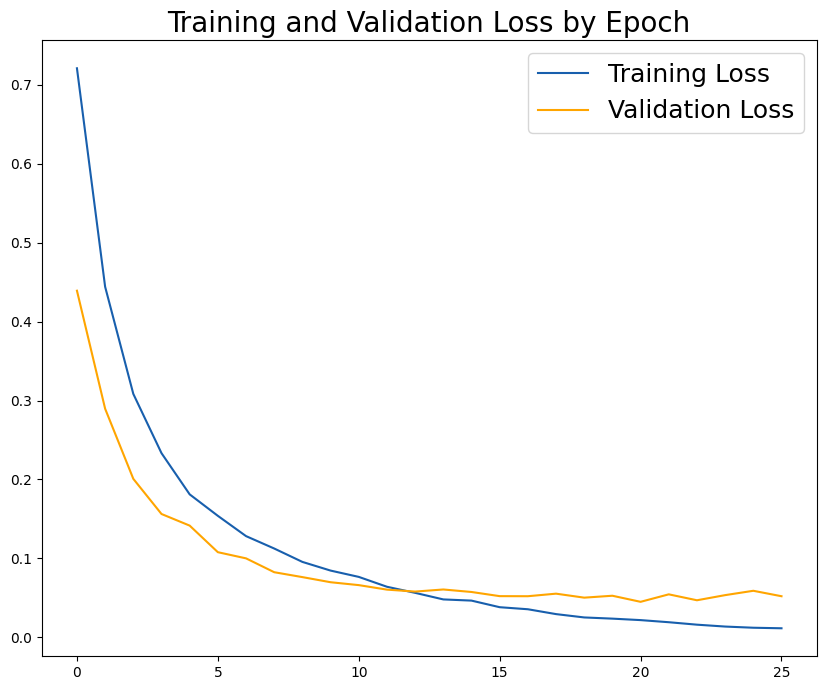

In [ ]:
plt.figure(figsize=(10, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(hist_1.history['loss'], label='Training Loss', color='#185fad')
plt.plot(hist_1.history['val_loss'], label='Validation Loss', color='orange')
# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 20)
plt.legend(fontsize = 18);

2/2 [==============================] - 0s 9ms/step - loss: 0.2265 - auc_1: 0.9702
test evaluation [0.2264954000711441, 0.9701753854751587]
2/2 [==============================] - 0s 8ms/step


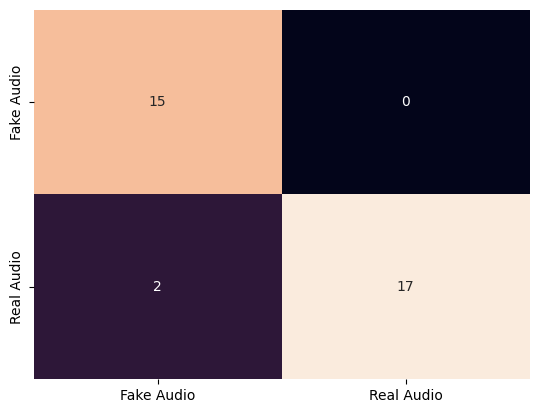

In [ ]:
print('test evaluation', model_1.evaluate(X_test_data, y_test))
cm = confusion_matrix(y_test, y_pred=tf.round(model_1.predict(X_test_data)))
ax = sns.heatmap(cm, annot=True, cbar=False)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Fake Audio', 'Real Audio'])
ax.yaxis.set_ticklabels(['Fake Audio', 'Real Audio'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
predictions_ = X_test.reset_index(drop=True)
predictions_['y_true'] = y_test
pred = np.round(model_1.predict(X_test_data)).reshape(34,)
predictions_['y_pred'] = pred
predictions_[predictions_.y_true != predictions_.y_pred]

2/2 [==============================] - 0s 6ms/step


,file,y_true,y_pred
2,/content/drive/MyDrive/real_audio/sample-00231...,1,0.0
21,/content/drive/MyDrive/real_audio/sample-00202...,1,0.0


In [ ]:
from IPython.display import Audio
Audio(predictions_.file[2], autoplay=True)

In [ ]:
Audio(predictions_.file[21], autoplay=True)

In [ ]:
predictions_[predictions_.y_true == predictions_.y_pred]

,file,y_true,y_pred
0,/content/drive/MyDrive/real_audio/sample-00003...,1,1.0
1,/content/drive/MyDrive/real_audio/sample-00040...,1,1.0
3,/content/drive/MyDrive/synthesized_audio_long_...,0,0.0
4,/content/drive/MyDrive/real_audio/sample-00151...,1,1.0
5,/content/drive/MyDrive/synthesized_audio_long_...,0,0.0
6,/content/drive/MyDrive/real_audio/sample-00221...,1,1.0
7,/content/drive/MyDrive/real_audio/sample-00247...,1,1.0
8,/content/drive/MyDrive/real_audio/sample-00295...,1,1.0
9,/content/drive/MyDrive/synthesized_audio_long_...,0,0.0
10,/content/drive/MyDrive/real_audio/sample-00061...,1,1.0


In [ ]:
Audio(predictions_.file[3], autoplay=True)

In [ ]:
Audio(predictions_.file[28], autoplay=True)